In [1]:
import time
from tqdm import tqdm
from transformers import ViTForImageClassification, ViTFeatureExtractor
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler

class CustomClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(CustomClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, num_classes)
        self.bn0 = nn.BatchNorm1d(input_dim)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)
        self.bn4 = nn.BatchNorm1d(64)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        
    def forward(self, x):

        #x = self.bn0(x)

        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc5(x)
        return x
    
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', ignore_mismatched_sizes=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

c:\Users\zln92\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\zln92\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [2]:
# Freeze all layers initially
for param in model.parameters():
    param.requires_grad = False

input_dim = model.classifier.in_features
num_classes = 7
model.classifier = CustomClassifier(input_dim, num_classes)
model.classifier.to(device)

'''
for param in model.vit.parameters():
    param.requires_grad = True
'''

optimizer = optim.Adam(model.classifier.parameters(), lr=2e-4) # try 0.01 0.001
criterion = nn.CrossEntropyLoss()

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

# Define a schedule to unfreeze layers gradually
unfreeze_schedule = {
    2: 'vit.encoder.layer.11',
    4: 'vit.encoder.layer.10',
    6: 'vit.encoder.layer.9',
    8: 'vit.encoder.layer.8',
    10: 'vit.encoder.layer.7',
    12: 'vit.encoder.layer.6',
    14: 'vit.encoder.layer.5',
    16: 'vit.encoder.layer.4',
    18: 'vit.encoder.layer.3',
}

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

train_dataset = datasets.ImageFolder(root='archive/train', transform=transform)
test_dataset = datasets.ImageFolder(root='archive/test', transform=transform)

class_counts = {"angry": 3995, "disgust": 436, "fear": 4097, "happy": 7215, "neutral": 4965, "sad": 4830, "surprise":3171}

weights = [1.0 / counts for counts in class_counts.values()]
labels = train_dataset.classes
sample_weights = [weights[label] for _, label in train_dataset.samples]

# Create sampler and DataLoader for training
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

train_loader = DataLoader(dataset=train_dataset, batch_size=32, sampler=sampler, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    progress_bar = tqdm(dataloader, desc='Training')
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())
    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    progress_bar = tqdm(dataloader, desc='Evaluating')
    with torch.no_grad():
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            progress_bar.set_postfix(loss=loss.item())
    accuracy = correct / len(dataloader.dataset)
    return total_loss / len(dataloader), accuracy

# Lists to store metrics
train_losses = []
val_losses = []
lr_list = []

num_epochs = 24
best_val_loss = float('inf')

for epoch in range(num_epochs):
    start_time = time.time()
    train_loss = train(model, train_loader, optimizer, criterion, device)

    # Gradually unfreeze layers
    if epoch in unfreeze_schedule:
        for name, param in model.named_parameters():
            if unfreeze_schedule[epoch] in name:
                param.requires_grad = True
                print(f'Unfroze layer: {name}')
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)

    val_loss, val_accuracy = evaluate(model, test_loader, criterion, device)
    end_time = time.time()
    epoch_duration = end_time - start_time
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    lr_list.append(optimizer.param_groups[0]['lr'])
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Time: {epoch_duration:.2f}s")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print('-' * 30)
    
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'vit_fer2013_v1_6-6-upscale.pth') #test 1 unfroze 4 layer from head, test 2 unfroze 9 layers
        print(f"Model saved with validation loss: {val_loss:.4f}")

print(f"Best model saved with validation loss: {best_val_loss:.4f}")

Evaluating: 100%|██████████| 225/225 [00:40<00:00,  5.50it/s, loss=1.02] 
c:\Users\zln92\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/24
Time: 237.24s
Train Loss: 1.7441
Validation Loss: 1.4252
Validation Accuracy: 0.4870
------------------------------
Model saved with validation loss: 1.4252


Evaluating: 100%|██████████| 225/225 [00:41<00:00,  5.42it/s, loss=0.777]


Epoch 2/24
Time: 220.15s
Train Loss: 1.4111
Validation Loss: 1.2372
Validation Accuracy: 0.5400
------------------------------
Model saved with validation loss: 1.2372


Training: 100%|██████████| 898/898 [02:54<00:00,  5.15it/s, loss=1.41] 


Unfroze layer: vit.encoder.layer.11.attention.attention.query.weight
Unfroze layer: vit.encoder.layer.11.attention.attention.query.bias
Unfroze layer: vit.encoder.layer.11.attention.attention.key.weight
Unfroze layer: vit.encoder.layer.11.attention.attention.key.bias
Unfroze layer: vit.encoder.layer.11.attention.attention.value.weight
Unfroze layer: vit.encoder.layer.11.attention.attention.value.bias
Unfroze layer: vit.encoder.layer.11.attention.output.dense.weight
Unfroze layer: vit.encoder.layer.11.attention.output.dense.bias
Unfroze layer: vit.encoder.layer.11.intermediate.dense.weight
Unfroze layer: vit.encoder.layer.11.intermediate.dense.bias
Unfroze layer: vit.encoder.layer.11.output.dense.weight
Unfroze layer: vit.encoder.layer.11.output.dense.bias
Unfroze layer: vit.encoder.layer.11.layernorm_before.weight
Unfroze layer: vit.encoder.layer.11.layernorm_before.bias
Unfroze layer: vit.encoder.layer.11.layernorm_after.weight
Unfroze layer: vit.encoder.layer.11.layernorm_after.bias


Evaluating: 100%|██████████| 225/225 [00:41<00:00,  5.46it/s, loss=0.639]


Epoch 3/24
Time: 215.64s
Train Loss: 1.2995
Validation Loss: 1.1771
Validation Accuracy: 0.5644
------------------------------
Model saved with validation loss: 1.1771


Evaluating: 100%|██████████| 225/225 [00:40<00:00,  5.51it/s, loss=0.644]


Epoch 4/24
Time: 233.60s
Train Loss: 1.2225
Validation Loss: 1.1600
Validation Accuracy: 0.5653
------------------------------
Model saved with validation loss: 1.1600


Training: 100%|██████████| 898/898 [03:09<00:00,  4.75it/s, loss=0.874]


Unfroze layer: vit.encoder.layer.10.attention.attention.query.weight
Unfroze layer: vit.encoder.layer.10.attention.attention.query.bias
Unfroze layer: vit.encoder.layer.10.attention.attention.key.weight
Unfroze layer: vit.encoder.layer.10.attention.attention.key.bias
Unfroze layer: vit.encoder.layer.10.attention.attention.value.weight
Unfroze layer: vit.encoder.layer.10.attention.attention.value.bias
Unfroze layer: vit.encoder.layer.10.attention.output.dense.weight
Unfroze layer: vit.encoder.layer.10.attention.output.dense.bias
Unfroze layer: vit.encoder.layer.10.intermediate.dense.weight
Unfroze layer: vit.encoder.layer.10.intermediate.dense.bias
Unfroze layer: vit.encoder.layer.10.output.dense.weight
Unfroze layer: vit.encoder.layer.10.output.dense.bias
Unfroze layer: vit.encoder.layer.10.layernorm_before.weight
Unfroze layer: vit.encoder.layer.10.layernorm_before.bias
Unfroze layer: vit.encoder.layer.10.layernorm_after.weight
Unfroze layer: vit.encoder.layer.10.layernorm_after.bias


Evaluating: 100%|██████████| 225/225 [00:40<00:00,  5.49it/s, loss=0.649]


Epoch 5/24
Time: 230.05s
Train Loss: 1.2004
Validation Loss: 1.1398
Validation Accuracy: 0.5763
------------------------------
Model saved with validation loss: 1.1398


Evaluating: 100%|██████████| 225/225 [00:41<00:00,  5.48it/s, loss=0.615]


Epoch 6/24
Time: 250.50s
Train Loss: 1.1725
Validation Loss: 1.1231
Validation Accuracy: 0.5850
------------------------------
Model saved with validation loss: 1.1231


Training: 100%|██████████| 898/898 [03:29<00:00,  4.28it/s, loss=1.24] 


Unfroze layer: vit.encoder.layer.9.attention.attention.query.weight
Unfroze layer: vit.encoder.layer.9.attention.attention.query.bias
Unfroze layer: vit.encoder.layer.9.attention.attention.key.weight
Unfroze layer: vit.encoder.layer.9.attention.attention.key.bias
Unfroze layer: vit.encoder.layer.9.attention.attention.value.weight
Unfroze layer: vit.encoder.layer.9.attention.attention.value.bias
Unfroze layer: vit.encoder.layer.9.attention.output.dense.weight
Unfroze layer: vit.encoder.layer.9.attention.output.dense.bias
Unfroze layer: vit.encoder.layer.9.intermediate.dense.weight
Unfroze layer: vit.encoder.layer.9.intermediate.dense.bias
Unfroze layer: vit.encoder.layer.9.output.dense.weight
Unfroze layer: vit.encoder.layer.9.output.dense.bias
Unfroze layer: vit.encoder.layer.9.layernorm_before.weight
Unfroze layer: vit.encoder.layer.9.layernorm_before.bias
Unfroze layer: vit.encoder.layer.9.layernorm_after.weight
Unfroze layer: vit.encoder.layer.9.layernorm_after.bias


Evaluating: 100%|██████████| 225/225 [00:40<00:00,  5.50it/s, loss=0.609]


Epoch 7/24
Time: 250.62s
Train Loss: 1.1408
Validation Loss: 1.1011
Validation Accuracy: 0.5871
------------------------------
Model saved with validation loss: 1.1011


Evaluating: 100%|██████████| 225/225 [00:41<00:00,  5.46it/s, loss=0.575]


Epoch 8/24
Time: 271.84s
Train Loss: 1.1032
Validation Loss: 1.0789
Validation Accuracy: 0.6013
------------------------------
Model saved with validation loss: 1.0789


Training: 100%|██████████| 898/898 [03:50<00:00,  3.90it/s, loss=0.873]


Unfroze layer: vit.encoder.layer.8.attention.attention.query.weight
Unfroze layer: vit.encoder.layer.8.attention.attention.query.bias
Unfroze layer: vit.encoder.layer.8.attention.attention.key.weight
Unfroze layer: vit.encoder.layer.8.attention.attention.key.bias
Unfroze layer: vit.encoder.layer.8.attention.attention.value.weight
Unfroze layer: vit.encoder.layer.8.attention.attention.value.bias
Unfroze layer: vit.encoder.layer.8.attention.output.dense.weight
Unfroze layer: vit.encoder.layer.8.attention.output.dense.bias
Unfroze layer: vit.encoder.layer.8.intermediate.dense.weight
Unfroze layer: vit.encoder.layer.8.intermediate.dense.bias
Unfroze layer: vit.encoder.layer.8.output.dense.weight
Unfroze layer: vit.encoder.layer.8.output.dense.bias
Unfroze layer: vit.encoder.layer.8.layernorm_before.weight
Unfroze layer: vit.encoder.layer.8.layernorm_before.bias
Unfroze layer: vit.encoder.layer.8.layernorm_after.weight
Unfroze layer: vit.encoder.layer.8.layernorm_after.bias


Evaluating: 100%|██████████| 225/225 [00:41<00:00,  5.44it/s, loss=0.429]


Epoch 9/24
Time: 271.79s
Train Loss: 1.0522
Validation Loss: 1.0653
Validation Accuracy: 0.6109
------------------------------
Model saved with validation loss: 1.0653


Evaluating: 100%|██████████| 225/225 [00:40<00:00,  5.51it/s, loss=0.523]


Epoch 10/24
Time: 292.58s
Train Loss: 1.0306
Validation Loss: 1.0380
Validation Accuracy: 0.6135
------------------------------
Model saved with validation loss: 1.0380


Training: 100%|██████████| 898/898 [04:11<00:00,  3.57it/s, loss=1.7]  


Unfroze layer: vit.encoder.layer.7.attention.attention.query.weight
Unfroze layer: vit.encoder.layer.7.attention.attention.query.bias
Unfroze layer: vit.encoder.layer.7.attention.attention.key.weight
Unfroze layer: vit.encoder.layer.7.attention.attention.key.bias
Unfroze layer: vit.encoder.layer.7.attention.attention.value.weight
Unfroze layer: vit.encoder.layer.7.attention.attention.value.bias
Unfroze layer: vit.encoder.layer.7.attention.output.dense.weight
Unfroze layer: vit.encoder.layer.7.attention.output.dense.bias
Unfroze layer: vit.encoder.layer.7.intermediate.dense.weight
Unfroze layer: vit.encoder.layer.7.intermediate.dense.bias
Unfroze layer: vit.encoder.layer.7.output.dense.weight
Unfroze layer: vit.encoder.layer.7.output.dense.bias
Unfroze layer: vit.encoder.layer.7.layernorm_before.weight
Unfroze layer: vit.encoder.layer.7.layernorm_before.bias
Unfroze layer: vit.encoder.layer.7.layernorm_after.weight
Unfroze layer: vit.encoder.layer.7.layernorm_after.bias


Evaluating: 100%|██████████| 225/225 [00:40<00:00,  5.51it/s, loss=0.43] 


Epoch 11/24
Time: 292.35s
Train Loss: 0.9893
Validation Loss: 1.0342
Validation Accuracy: 0.6223
------------------------------
Model saved with validation loss: 1.0342


Evaluating: 100%|██████████| 225/225 [00:40<00:00,  5.50it/s, loss=0.631]


Epoch 12/24
Time: 314.31s
Train Loss: 0.9517
Validation Loss: 1.0026
Validation Accuracy: 0.6390
------------------------------
Model saved with validation loss: 1.0026


Training: 100%|██████████| 898/898 [04:33<00:00,  3.28it/s, loss=1.01] 


Unfroze layer: vit.encoder.layer.6.attention.attention.query.weight
Unfroze layer: vit.encoder.layer.6.attention.attention.query.bias
Unfroze layer: vit.encoder.layer.6.attention.attention.key.weight
Unfroze layer: vit.encoder.layer.6.attention.attention.key.bias
Unfroze layer: vit.encoder.layer.6.attention.attention.value.weight
Unfroze layer: vit.encoder.layer.6.attention.attention.value.bias
Unfroze layer: vit.encoder.layer.6.attention.output.dense.weight
Unfroze layer: vit.encoder.layer.6.attention.output.dense.bias
Unfroze layer: vit.encoder.layer.6.intermediate.dense.weight
Unfroze layer: vit.encoder.layer.6.intermediate.dense.bias
Unfroze layer: vit.encoder.layer.6.output.dense.weight
Unfroze layer: vit.encoder.layer.6.output.dense.bias
Unfroze layer: vit.encoder.layer.6.layernorm_before.weight
Unfroze layer: vit.encoder.layer.6.layernorm_before.bias
Unfroze layer: vit.encoder.layer.6.layernorm_after.weight
Unfroze layer: vit.encoder.layer.6.layernorm_after.bias


Evaluating: 100%|██████████| 225/225 [00:40<00:00,  5.50it/s, loss=0.513]


Epoch 13/24
Time: 314.62s
Train Loss: 0.8967
Validation Loss: 0.9873
Validation Accuracy: 0.6450
------------------------------
Model saved with validation loss: 0.9873


Evaluating: 100%|██████████| 225/225 [00:41<00:00,  5.47it/s, loss=0.668]


Epoch 14/24
Time: 336.80s
Train Loss: 0.8518
Validation Loss: 0.9730
Validation Accuracy: 0.6420
------------------------------
Model saved with validation loss: 0.9730


Training: 100%|██████████| 898/898 [04:56<00:00,  3.03it/s, loss=0.791]


Unfroze layer: vit.encoder.layer.5.attention.attention.query.weight
Unfroze layer: vit.encoder.layer.5.attention.attention.query.bias
Unfroze layer: vit.encoder.layer.5.attention.attention.key.weight
Unfroze layer: vit.encoder.layer.5.attention.attention.key.bias
Unfroze layer: vit.encoder.layer.5.attention.attention.value.weight
Unfroze layer: vit.encoder.layer.5.attention.attention.value.bias
Unfroze layer: vit.encoder.layer.5.attention.output.dense.weight
Unfroze layer: vit.encoder.layer.5.attention.output.dense.bias
Unfroze layer: vit.encoder.layer.5.intermediate.dense.weight
Unfroze layer: vit.encoder.layer.5.intermediate.dense.bias
Unfroze layer: vit.encoder.layer.5.output.dense.weight
Unfroze layer: vit.encoder.layer.5.output.dense.bias
Unfroze layer: vit.encoder.layer.5.layernorm_before.weight
Unfroze layer: vit.encoder.layer.5.layernorm_before.bias
Unfroze layer: vit.encoder.layer.5.layernorm_after.weight
Unfroze layer: vit.encoder.layer.5.layernorm_after.bias


Evaluating: 100%|██████████| 225/225 [00:41<00:00,  5.44it/s, loss=0.547]


Epoch 15/24
Time: 338.00s
Train Loss: 0.8035
Validation Loss: 0.9692
Validation Accuracy: 0.6498
------------------------------
Model saved with validation loss: 0.9692


Evaluating: 100%|██████████| 225/225 [00:41<00:00,  5.45it/s, loss=0.39] 


Epoch 16/24
Time: 359.40s
Train Loss: 0.7493
Validation Loss: 0.9523
Validation Accuracy: 0.6590
------------------------------
Model saved with validation loss: 0.9523


Training: 100%|██████████| 898/898 [05:18<00:00,  2.82it/s, loss=0.829]


Unfroze layer: vit.encoder.layer.4.attention.attention.query.weight
Unfroze layer: vit.encoder.layer.4.attention.attention.query.bias
Unfroze layer: vit.encoder.layer.4.attention.attention.key.weight
Unfroze layer: vit.encoder.layer.4.attention.attention.key.bias
Unfroze layer: vit.encoder.layer.4.attention.attention.value.weight
Unfroze layer: vit.encoder.layer.4.attention.attention.value.bias
Unfroze layer: vit.encoder.layer.4.attention.output.dense.weight
Unfroze layer: vit.encoder.layer.4.attention.output.dense.bias
Unfroze layer: vit.encoder.layer.4.intermediate.dense.weight
Unfroze layer: vit.encoder.layer.4.intermediate.dense.bias
Unfroze layer: vit.encoder.layer.4.output.dense.weight
Unfroze layer: vit.encoder.layer.4.output.dense.bias
Unfroze layer: vit.encoder.layer.4.layernorm_before.weight
Unfroze layer: vit.encoder.layer.4.layernorm_before.bias
Unfroze layer: vit.encoder.layer.4.layernorm_after.weight
Unfroze layer: vit.encoder.layer.4.layernorm_after.bias


Evaluating: 100%|██████████| 225/225 [00:41<00:00,  5.48it/s, loss=0.545]


Epoch 17/24
Time: 359.64s
Train Loss: 0.6974
Validation Loss: 0.9561
Validation Accuracy: 0.6558
------------------------------


Evaluating: 100%|██████████| 225/225 [00:41<00:00,  5.46it/s, loss=0.525]


Epoch 18/24
Time: 380.40s
Train Loss: 0.6423
Validation Loss: 0.9520
Validation Accuracy: 0.6634
------------------------------
Model saved with validation loss: 0.9520


Training: 100%|██████████| 898/898 [05:38<00:00,  2.65it/s, loss=0.714]


Unfroze layer: vit.encoder.layer.3.attention.attention.query.weight
Unfroze layer: vit.encoder.layer.3.attention.attention.query.bias
Unfroze layer: vit.encoder.layer.3.attention.attention.key.weight
Unfroze layer: vit.encoder.layer.3.attention.attention.key.bias
Unfroze layer: vit.encoder.layer.3.attention.attention.value.weight
Unfroze layer: vit.encoder.layer.3.attention.attention.value.bias
Unfroze layer: vit.encoder.layer.3.attention.output.dense.weight
Unfroze layer: vit.encoder.layer.3.attention.output.dense.bias
Unfroze layer: vit.encoder.layer.3.intermediate.dense.weight
Unfroze layer: vit.encoder.layer.3.intermediate.dense.bias
Unfroze layer: vit.encoder.layer.3.output.dense.weight
Unfroze layer: vit.encoder.layer.3.output.dense.bias
Unfroze layer: vit.encoder.layer.3.layernorm_before.weight
Unfroze layer: vit.encoder.layer.3.layernorm_before.bias
Unfroze layer: vit.encoder.layer.3.layernorm_after.weight
Unfroze layer: vit.encoder.layer.3.layernorm_after.bias


Evaluating: 100%|██████████| 225/225 [00:41<00:00,  5.47it/s, loss=0.324]


Epoch 19/24
Time: 379.99s
Train Loss: 0.5889
Validation Loss: 0.9646
Validation Accuracy: 0.6553
------------------------------


Evaluating: 100%|██████████| 225/225 [00:41<00:00,  5.42it/s, loss=0.462]


Epoch 20/24
Time: 401.79s
Train Loss: 0.5350
Validation Loss: 0.9585
Validation Accuracy: 0.6641
------------------------------


Evaluating: 100%|██████████| 225/225 [00:40<00:00,  5.49it/s, loss=0.482]


Epoch 21/24
Time: 401.65s
Train Loss: 0.4821
Validation Loss: 0.9890
Validation Accuracy: 0.6598
------------------------------


Evaluating: 100%|██████████| 225/225 [00:40<00:00,  5.49it/s, loss=0.312]


Epoch 22/24
Time: 400.88s
Train Loss: 0.4438
Validation Loss: 0.9723
Validation Accuracy: 0.6705
------------------------------


Evaluating: 100%|██████████| 225/225 [01:10<00:00,  3.21it/s, loss=0.284]


Epoch 23/24
Time: 477.05s
Train Loss: 0.3896
Validation Loss: 0.9921
Validation Accuracy: 0.6648
------------------------------


Evaluating: 100%|██████████| 225/225 [00:41<00:00,  5.44it/s, loss=0.489]

Epoch 24/24
Time: 443.97s
Train Loss: 0.3508
Validation Loss: 1.0252
Validation Accuracy: 0.6553
------------------------------
Best model saved with validation loss: 0.9520


In [3]:
for name, param in model.named_parameters():
    print(name)

vit.embeddings.cls_token
vit.embeddings.position_embeddings
vit.embeddings.patch_embeddings.projection.weight
vit.embeddings.patch_embeddings.projection.bias
vit.encoder.layer.0.attention.attention.query.weight
vit.encoder.layer.0.attention.attention.query.bias
vit.encoder.layer.0.attention.attention.key.weight
vit.encoder.layer.0.attention.attention.key.bias
vit.encoder.layer.0.attention.attention.value.weight
vit.encoder.layer.0.attention.attention.value.bias
vit.encoder.layer.0.attention.output.dense.weight
vit.encoder.layer.0.attention.output.dense.bias
vit.encoder.layer.0.intermediate.dense.weight
vit.encoder.layer.0.intermediate.dense.bias
vit.encoder.layer.0.output.dense.weight
vit.encoder.layer.0.output.dense.bias
vit.encoder.layer.0.layernorm_before.weight
vit.encoder.layer.0.layernorm_before.bias
vit.encoder.layer.0.layernorm_after.weight
vit.encoder.layer.0.layernorm_after.bias
vit.encoder.layer.1.attention.attention.query.weight
vit.encoder.layer.1.attention.attention.query

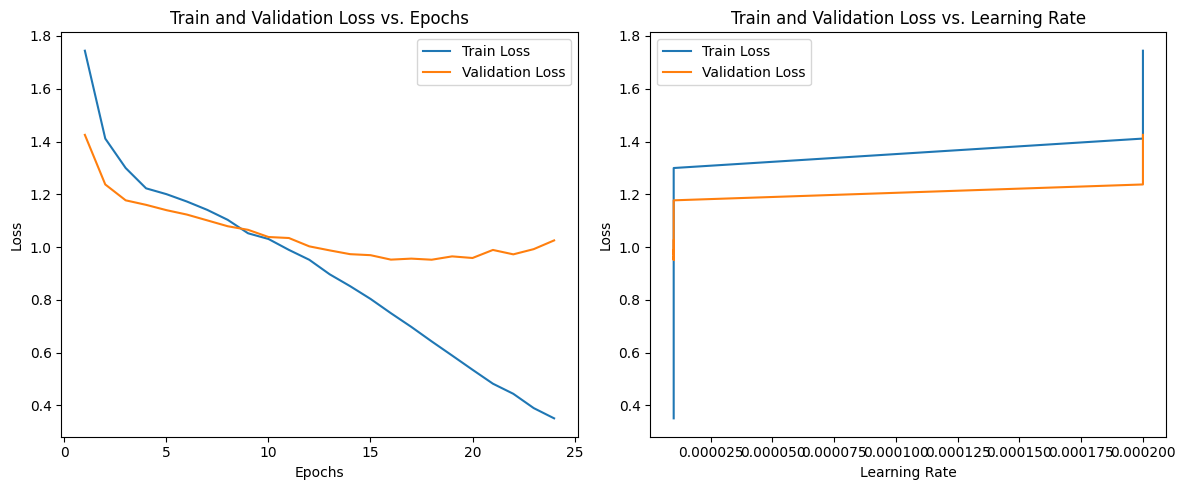

In [4]:
# Plotting
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot train and validation loss against epochs
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss vs. Epochs')
plt.legend()

# Plot train and validation loss against learning rates
plt.subplot(1, 2, 2)
plt.plot(lr_list, train_losses, label='Train Loss')
plt.plot(lr_list, val_losses, label='Validation Loss')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Train and Validation Loss vs. Learning Rate')
plt.legend()

plt.tight_layout()
plt.show()

C:\Users\zln92\AppData\Local\Temp\ipykernel_21364\1806678823.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_accuracies, y=category_names, ax=ax, palette='viridis')


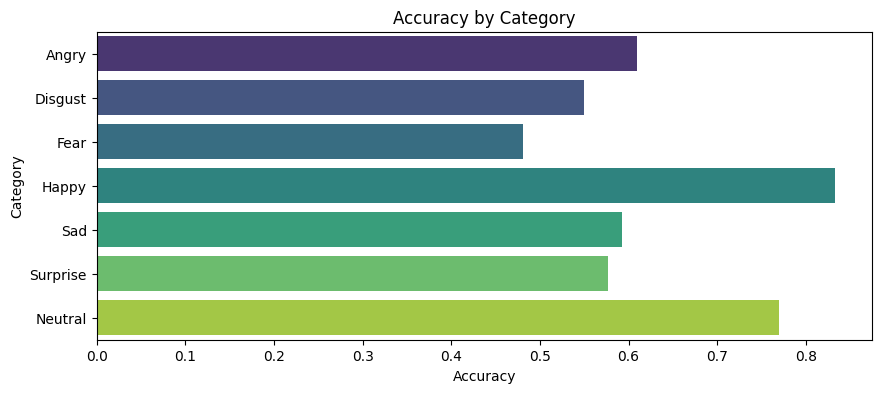

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score

def calculate_category_accuracies(model, dataloader, device, num_classes):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, preds = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(preds.cpu().numpy())

    category_accuracies = []
    for i in range(num_classes):
        category_mask = (np.array(true_labels) == i)
        category_acc = accuracy_score(np.array(true_labels)[category_mask], np.array(predicted_labels)[category_mask])
        category_accuracies.append(category_acc)

    return category_accuracies

category_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

category_accuracies = calculate_category_accuracies(model, test_loader, device, num_classes)

fig, ax = plt.subplots(figsize=(10, 4))  
sns.barplot(x=category_accuracies, y=category_names, ax=ax, palette='viridis')
ax.set_xlabel('Accuracy')
ax.set_ylabel('Category')
ax.set_title('Accuracy by Category')
plt.show()

In [6]:
category_names, category_accuracies

(['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'],
 [0.6096033402922756,
  0.5495495495495496,
  0.4814453125,
  0.8325817361894025,
  0.592051905920519,
  0.5765838011226945,
  0.7701564380264742])

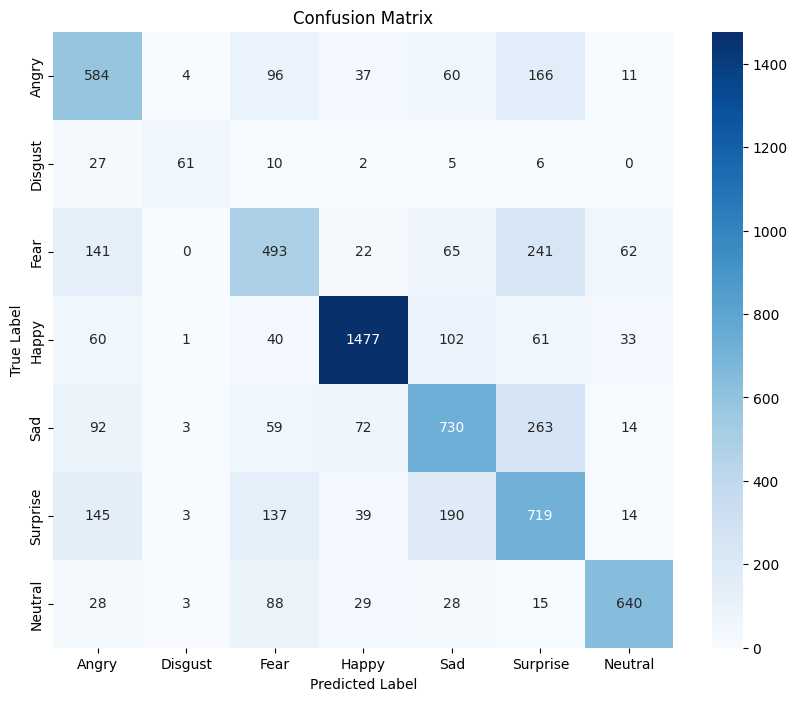

In [7]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, dataloader, device, num_classes, category_names):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, preds = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(preds.cpu().numpy())

    cm = confusion_matrix(true_labels, predicted_labels, labels=range(num_classes))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

category_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

plot_confusion_matrix(model, test_loader, device, num_classes, category_names)